## Importing the libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score,roc_curve, accuracy_score

## Importing the Processed data

In [3]:
train = pd.read_csv('Final_train.csv')
train = train.sample(frac=1,random_state=3)
test  = pd.read_csv('Final_test.csv')
test  = test.sample(frac=1,random_state=3)

**Dropping unnamed columns**

In [4]:
train.drop(columns='Unnamed: 0',inplace =True)
test.drop(columns='Unnamed: 0',inplace =True)

**Checking the shape of the data to check for uniformity**

In [5]:
train.shape,test.shape

((141360, 16), (17814, 16))

**Checking the top 5 rows of the data to check the nature of each columns.**

In [6]:
train.head()

,national_inv,lead_time,in_transit_qty,min_bank,pieces_past_due,local_bo_qty,potential_issue_Yes,deck_risk_Yes,oe_constraint_Yes,ppap_risk_Yes,stop_auto_buy_Yes,rev_stop_Yes,Sales_index,forecast_index,performance_index,went_on_backorder
136469,-0.032446,0.451557,2.294908,1.155135,-0.257536,-0.305683,0,0,0,0,1,0,1.851480,1.412060,0.209805,1
37885,-0.047131,0.660646,-0.478951,-0.899422,-0.257536,-0.305683,0,0,0,0,1,0,-2.482683,-1.956639,0.865696,0
61273,0.215371,0.469599,-0.478951,-0.899422,-0.257536,-0.305683,0,0,0,0,1,0,-2.482683,-1.956639,-1.241861,0
112767,-0.050721,-1.400905,-0.478951,-0.393197,-0.257536,-0.305683,0,1,0,1,1,0,-2.482683,0.503902,0.283167,1
91996,-0.050721,0.469599,-0.478951,-0.899422,-0.257536,-0.305683,0,0,0,0,1,0,-0.522973,-0.180814,0.037312,1


## Splitting the data into xtrain, xtest, ytrain and ytest respectively

In [7]:
xtrain = train.drop(columns=['went_on_backorder'])
ytrain = train['went_on_backorder']

xtest  = test.drop(columns=['went_on_backorder'])
ytest  = test['went_on_backorder']

## Defining a function for evaluation of models built

In [8]:
def model_eval(model,xtrain=xtrain, xtest=xtest, ytrain=ytrain, ytest=ytest):
    
    model.fit(xtrain,ytrain)
    
    yprob_train = model.predict_proba(xtrain)[:,1]
    yprob_test = model.predict_proba(xtest)[:,1]
    
    fpr,tpr,threshold = roc_curve(ytest,yprob_test)
    j = tpr-fpr
    i = np.argmax(j)
    best_th = threshold[i]
    
    ypred_train = list(map(lambda x :0 if x<best_th else 1,yprob_train))
    ypred_test  = list(map(lambda x :0 if x<best_th else 1,yprob_test))
    
    # for cross validation purpose, default accuracy score with default predictions
    acc_train_without= accuracy_score(ytrain,model.predict(xtrain))
    acc_test_without = accuracy_score(ytest,model.predict(xtest))
    print("Default accuracy score of the train data is: ",acc_train_without)
    print("Default accuracy score of the test data is: ",acc_test_without)
    
    # accuracy score with manually calculated threshold.
    ac_tr = accuracy_score(ytrain,ypred_train)
    ac_ts = accuracy_score(ytest, ypred_test)
    print("\nThreshhold defined accuracy score of the train data is: ",ac_tr)
    print("Threshhold defined accuracy score of the test data is: ",ac_ts)

    f1_tr = f1_score(ytrain,ypred_train,zero_division=0)
    f1_ts = f1_score(ytest ,ypred_test, zero_division=0)
    print("\nF1 score of the train data is: ",f1_tr)
    print("F1 score of the test data is: ",   f1_ts)

    roc_tr = roc_auc_score(ytrain,yprob_train)
    roc_ts = roc_auc_score(ytest, yprob_test)
    print("\nroc_auc_score of the train data is: ",roc_tr)
    print("roc_auc_score of the test data is: ",   roc_ts)

    print('\nClassification report train')
    print(classification_report(ytrain,ypred_train))

    print('\n\nClassification report test')
    print(classification_report(ytest,ypred_test))

    print('\nConfusion matrix train data')
    plt.figure(figsize=(5,3))
    cm2=confusion_matrix(ytrain,ypred_train)
    conf_matrix = pd.DataFrame(data = cm2,columns = ['Predicted:0','Predicted:1'], 
                               index = ['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show()
    
    
    print('\nConfusion matrix test data')
    plt.figure(figsize=(5,3))
    cm2=confusion_matrix(ytest,ypred_test)
    conf_matrix = pd.DataFrame(data = cm2,columns = ['Predicted:0','Predicted:1'], 
                               index = ['Actual:0','Actual:1'])
    sns.heatmap(conf_matrix, annot = True, fmt = 'd', cbar = False,linewidths = 0.1, annot_kws = {'size':25})
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.show() 
    
    cm = confusion_matrix(ytest,ypred_test)
    recall = cm[1,1]/(cm[1,1]+cm[1,0])
    print('\nRecall(TPR) for test data =',recall)
    
    fpr,tpr,thresholds = roc_curve(ytest, yprob_test)
    fpr1,tpr1,th1      = roc_curve(ytrain,yprob_train)
    
    plt.figure(figsize=(10,7))
    plt.plot(fpr,fpr)
    plt.plot(fpr1,tpr1,label='Train roc_curve')
    plt.plot(fpr,tpr,label='Test roc_curve')
    plt.xlabel('FPR',fontsize=14)
    plt.ylabel('TPR',fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend()
    plt.show()
    
    return f1_tr,f1_ts,roc_tr,roc_ts , acc_train_without,acc_test_without, recall

**Lists for model cross validation**

Models and accuracy scores are added after confirming their train and test performances.

In [56]:
# will only add models with high performance for cross validation
cv_model= [] 
model_name = []
test_acc = []
train_acc = []
rec = []

**Lists for tabulating the performances of each models.**

In [10]:
models           = []
f1_train_scores  = []
f1_test_scores   = []
roc_train_scores = []
roc_test_scores  = []
rec_test         = []

## RandomForest Classifier

Default accuracy score of the train data is:  0.9999009620826259
Default accuracy score of the test data is:  0.9864713146963062

Threshhold defined accuracy score of the train data is:  0.9530489530277306
Threshhold defined accuracy score of the test data is:  0.8312563152576625

F1 score of the train data is:  0.9551544963749266
F1 score of the test data is:  0.07164916615194565

roc_auc_score of the train data is:  0.9999984055167538
roc_auc_score of the test data is:  0.8904674232808918

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.91      0.95     70680
           1       0.91      1.00      0.96     70680

    accuracy                           0.95    141360
   macro avg       0.96      0.95      0.95    141360
weighted avg       0.96      0.95      0.95    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.83      0.91     17676
          

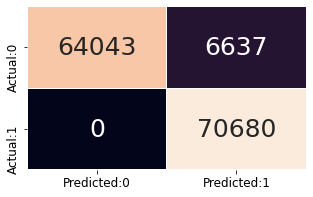


Confusion matrix test data


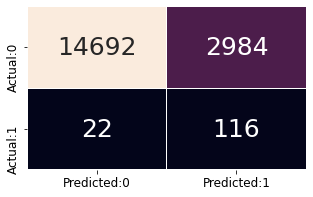


Recall(TPR) for test data = 0.8405797101449275


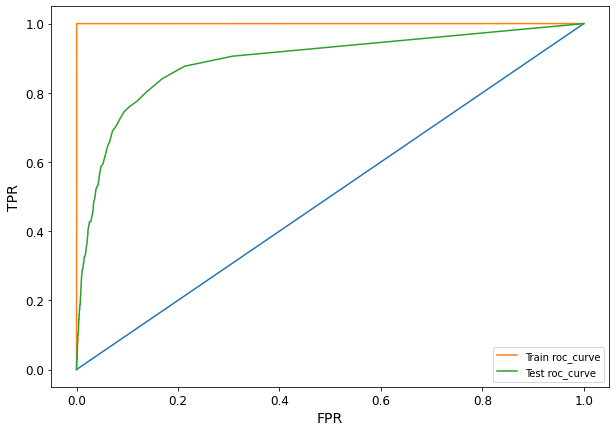

In [11]:
rf = RandomForestClassifier(random_state=3)
rf_train_f1, rf_test_f1, rf_train_roc, rf_test_roc, rf_acc_train, rf_acc_test,rf_rec = model_eval(rf)

In [12]:
models.append('RandomForest Classifier')
f1_train_scores.append(rf_train_f1)
f1_test_scores.append(rf_test_f1)
roc_train_scores.append(rf_train_roc)
roc_test_scores.append(rf_test_roc)
rec_test.append(rf_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.84058


## RandomForest - Hyperparameter Tuning

In [13]:
rf_tuned = RandomForestClassifier(random_state=3,n_jobs=-1)

params = {'n_estimators':np.arange(100,200,5), 'max_depth':np.arange(5,8)}

gscv = GridSearchCV(rf_tuned, param_grid = params, cv = 3,scoring='f1',n_jobs=-1,verbose=True)
gscv.fit(xtrain,ytrain)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=3),
             n_jobs=-1,
             param_grid={'max_depth': array([5, 6, 7]),
                         'n_estimators': array([100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155, 160,
       165, 170, 175, 180, 185, 190, 195])},
             scoring='f1', verbose=True)

Default accuracy score of the train data is:  0.9103353140916808
Default accuracy score of the test data is:  0.8761086785674189

Threshhold defined accuracy score of the train data is:  0.8834394453876627
Threshhold defined accuracy score of the test data is:  0.7875266644212418

F1 score of the train data is:  0.8938207641399398
F1 score of the test data is:  0.06056093323405311

roc_auc_score of the train data is:  0.9729583689442265
roc_auc_score of the test data is:  0.9036778354995392

Classification report train
              precision    recall  f1-score   support

           0       0.98      0.79      0.87     70680
           1       0.82      0.98      0.89     70680

    accuracy                           0.88    141360
   macro avg       0.90      0.88      0.88    141360
weighted avg       0.90      0.88      0.88    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.79      0.88     17676
          

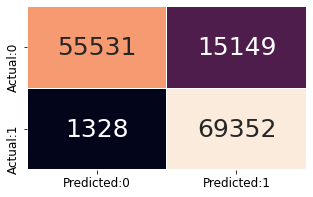


Confusion matrix test data


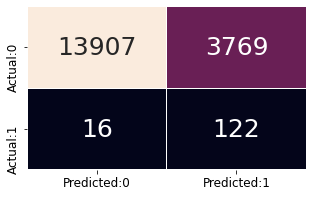


Recall(TPR) for test data = 0.8840579710144928


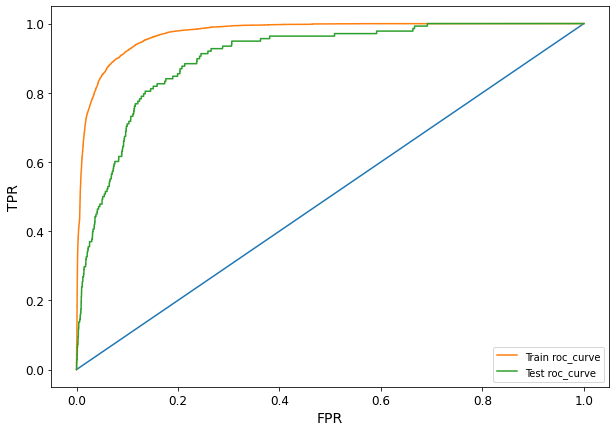

In [54]:
rf_tuned = RandomForestClassifier(random_state=3,n_jobs=-1,n_estimators=117,max_depth=7)
rf_tuned_train_f1,rf_tuned_test_f1, rf_tuned_train_roc,rf_tuned_test_roc, rf_tuned_train_acc,rf_tuned_test_acc,rf_tuned_rec = model_eval(rf_tuned)

In [57]:
cv_model.append(rf_tuned)
model_name.append('RandomForest Tuned Classifier')
train_acc.append(rf_tuned_train_acc)
test_acc.append(rf_tuned_test_acc)

In [17]:
models.append('RandomForest Tuned Classifier')
f1_train_scores.append(rf_tuned_train_f1)
f1_test_scores.append(rf_tuned_test_f1)
roc_train_scores.append(rf_tuned_train_roc)
roc_test_scores.append(rf_tuned_test_roc)
rec_test.append(rf_tuned_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348


## GradientBoosting

Default accuracy score of the train data is:  0.9442628749292586
Default accuracy score of the test data is:  0.9276973167171887

Threshhold defined accuracy score of the train data is:  0.9022849462365592
Threshhold defined accuracy score of the test data is:  0.8099809138879533

F1 score of the train data is:  0.9103604919043446
F1 score of the test data is:  0.06774993114844396

roc_auc_score of the train data is:  0.9864179301827922
roc_auc_score of the test data is:  0.9167910882191854

Classification report train
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     70680
           1       0.84      0.99      0.91     70680

    accuracy                           0.90    141360
   macro avg       0.92      0.90      0.90    141360
weighted avg       0.92      0.90      0.90    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.81      0.89     17676
          

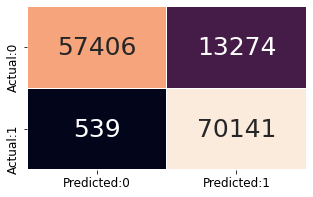


Confusion matrix test data


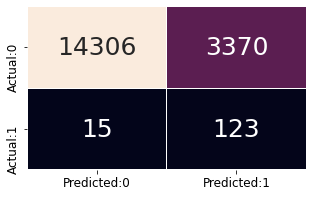


Recall(TPR) for test data = 0.8913043478260869


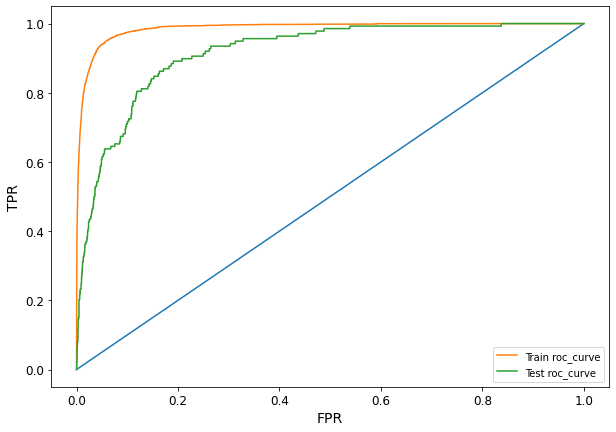

In [18]:
gb = GradientBoostingClassifier(random_state=3)

gb_train_f1,gb_test_f1,gb_train_roc,gb_test_roc, gb_train_acc,gb_test_acc,gb_rec = model_eval(gb)

In [19]:
models.append('GradientBoost Classifier')
f1_train_scores.append(gb_train_f1)
f1_test_scores.append(gb_test_f1)
roc_train_scores.append(gb_train_roc)
roc_test_scores.append(gb_test_roc)
rec_test.append(gb_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304


In [58]:
cv_model.append(gb)
model_name.append('GradientBoosting Base Model')
train_acc.append(gb_train_acc)
test_acc.append(gb_test_acc)

## GradientBoost - Hyperparameter Tuning

In [21]:
gb_tuned = GradientBoostingClassifier(random_state=3)

params = {'n_estimators':np.arange(119,140)}

gscv = GridSearchCV(gb_tuned,param_grid=params,cv=3,scoring='f1',verbose=True,n_jobs=-1)
gscv.fit(xtrain,ytrain)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=3),
             n_jobs=-1,
             param_grid={'n_estimators': array([119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139])},
             scoring='f1', verbose=True)

In [21]:
gscv.best_params_

{'n_estimators': 139}

Default accuracy score of the train data is:  0.952475947934352
Default accuracy score of the test data is:  0.9389244414505445

Threshhold defined accuracy score of the train data is:  0.9220783814374647
Threshhold defined accuracy score of the test data is:  0.8533176153587066

F1 score of the train data is:  0.9270872636045303
F1 score of the test data is:  0.0809004572634541

roc_auc_score of the train data is:  0.9901919535235207
roc_auc_score of the test data is:  0.9122038890036765

Classification report train
              precision    recall  f1-score   support

           0       0.99      0.85      0.92     70680
           1       0.87      0.99      0.93     70680

    accuracy                           0.92    141360
   macro avg       0.93      0.92      0.92    141360
weighted avg       0.93      0.92      0.92    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.85      0.92     17676
           1

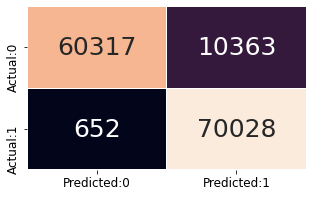


Confusion matrix test data


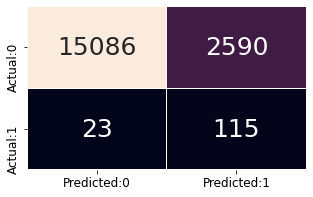


Recall(TPR) for test data = 0.8333333333333334


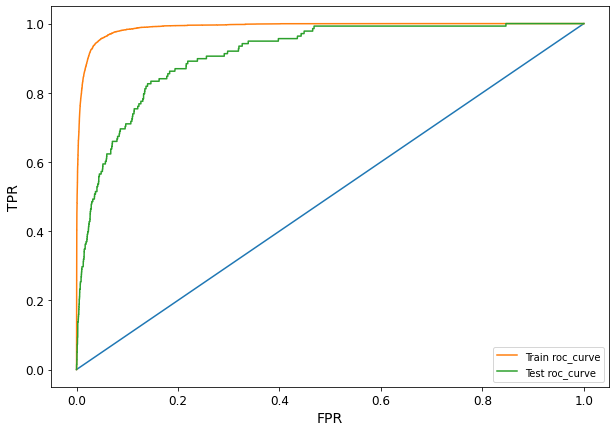

In [22]:
gb_tuned = GradientBoostingClassifier(random_state=3, n_estimators= 139)
gb_tuned_train_f1,gb_tuned_test_f1,gb_tuned_train_roc,gb_tuned_test_roc,gb_tuned_train_acc,gb_tuned_test_acc,gb_tuned_rec= model_eval(gb_tuned)

In [23]:
models.append('GradientBoost Tuned Classifier')
f1_train_scores.append(gb_tuned_train_f1)
f1_test_scores.append(gb_tuned_test_f1)
roc_train_scores.append(gb_tuned_train_roc)
roc_test_scores.append(gb_tuned_test_roc)
rec_test.append(gb_tuned_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333


## SGDClassifier

Default accuracy score of the train data is:  0.8358446519524618
Default accuracy score of the test data is:  0.8335578758280004

Threshhold defined accuracy score of the train data is:  0.8385540464063385
Threshhold defined accuracy score of the test data is:  0.824520040417649

F1 score of the train data is:  0.8409439380000556
F1 score of the test data is:  0.05956678700361011

roc_auc_score of the train data is:  0.9049196788197696
roc_auc_score of the test data is:  0.8267010701483384

Classification report train
              precision    recall  f1-score   support

           0       0.85      0.82      0.84     70680
           1       0.83      0.85      0.84     70680

    accuracy                           0.84    141360
   macro avg       0.84      0.84      0.84    141360
weighted avg       0.84      0.84      0.84    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.83      0.90     17676
           

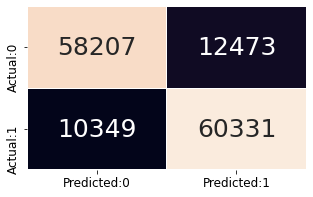


Confusion matrix test data


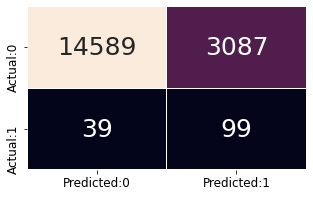


Recall(TPR) for test data = 0.717391304347826


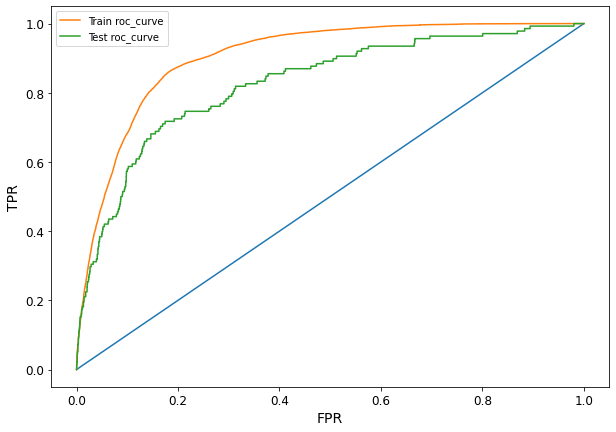

In [24]:
sgd = SGDClassifier(loss='log')

sgd_train_f1,sgd_test_f1,sgd_train_roc,sgd_test_roc,_,_,sg_rec = model_eval(sgd)

In [25]:
models.append('SGD Classifier')
f1_train_scores.append(sgd_train_f1)
f1_test_scores.append(sgd_test_f1)
roc_train_scores.append(sgd_train_roc)
roc_test_scores.append(sgd_test_roc)
rec_test.append(sg_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391


## SGDClassifier - Hyperparameter Tuning

In [26]:
sgd_t = SGDClassifier(max_iter=5000)

params = {'loss':['log','modified_huber'],
          'penalty':['l1','l2','elasticnet'],
          'alpha':[0.01,0.05,0.075,0.005],
          'l1_ratio':[0.15,0.1,0.075,0.05]}

gs = GridSearchCV(sgd_t,param_grid=params,cv=3,scoring='f1')
gs.fit(xtrain,ytrain)

GridSearchCV(cv=3, estimator=SGDClassifier(max_iter=5000),
             param_grid={'alpha': [0.01, 0.05, 0.075, 0.005],
                         'l1_ratio': [0.15, 0.1, 0.075, 0.05],
                         'loss': ['log', 'modified_huber'],
                         'penalty': ['l1', 'l2', 'elasticnet']},
             scoring='f1')

In [27]:
gs.best_params_

{'alpha': 0.005, 'l1_ratio': 0.1, 'loss': 'modified_huber', 'penalty': 'l1'}

Default accuracy score of the train data is:  0.8437818336162988
Default accuracy score of the test data is:  0.8388346244526776

Threshhold defined accuracy score of the train data is:  0.8423457838143746
Threshhold defined accuracy score of the test data is:  0.8442236443246884

F1 score of the train data is:  0.8420888542478566
F1 score of the test data is:  0.06972846128059

roc_auc_score of the train data is:  0.9139145242280584
roc_auc_score of the test data is:  0.8584341004424241

Classification report train
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     70680
           1       0.84      0.84      0.84     70680

    accuracy                           0.84    141360
   macro avg       0.84      0.84      0.84    141360
weighted avg       0.84      0.84      0.84    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     17676
           1 

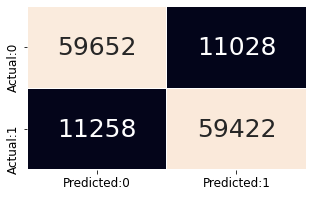


Confusion matrix test data


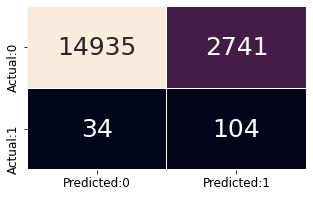


Recall(TPR) for test data = 0.7536231884057971


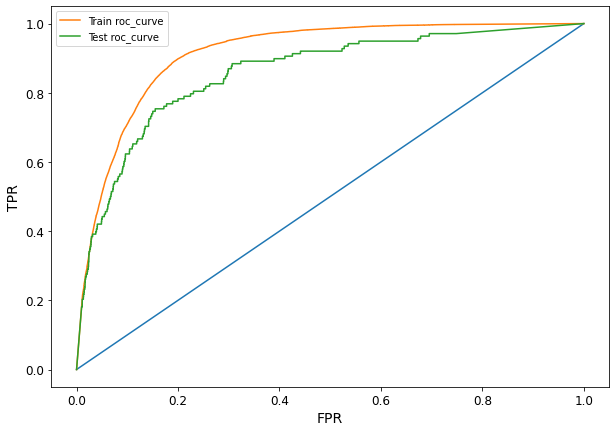

In [28]:
sgd_t = SGDClassifier(alpha=0.005,l1_ratio=0.1,loss='modified_huber',penalty='l1')
sgd_tuned_train_f1,sgd_tuned_test_f1,sgd_tuned_train_roc, sgd_tuned_test_roc,_,_,sgd_tuned_rec =model_eval(sgd_t)

In [29]:
models.append('SGD Tuned Classifier')
f1_train_scores.append(sgd_tuned_train_f1)
f1_test_scores.append(sgd_tuned_test_f1)
roc_train_scores.append(sgd_tuned_train_roc)
roc_test_scores.append(sgd_tuned_test_roc)
rec_test.append(sgd_tuned_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623


## XGBoost

In [30]:
from xgboost import XGBClassifier

[19:05:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Default accuracy score of the train data is:  0.9928975664968874
Default accuracy score of the test data is:  0.9816997866846301

Threshhold defined accuracy score of the train data is:  0.9386955291454443
Threshhold defined accuracy score of the test data is:  0.8740877961154149

F1 score of the train data is:  0.9422220444302211
F1 score of the test data is:  0.08261758691206546

roc_auc_score of the train data is:  0.9996881998070967
roc_auc_score of the test data is:  0.8816886320926434

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.88      0.93     70680
           1       0.89      1.00      0.94     70680

 

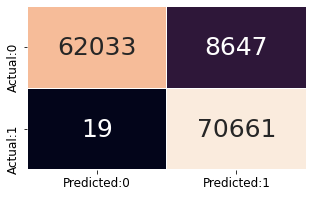


Confusion matrix test data


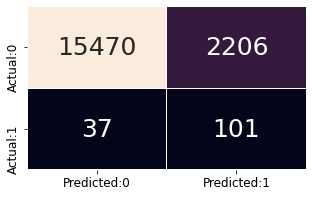


Recall(TPR) for test data = 0.7318840579710145


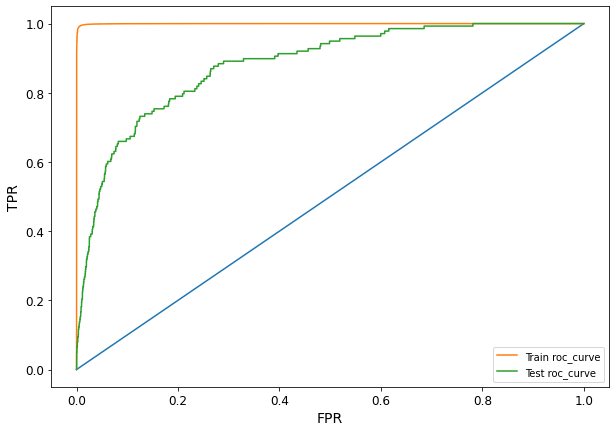

In [31]:
xg = XGBClassifier(use_label_encoder=False)

xgb_train_f1, xgb_test_f1, xgb_train_roc, xgb_test_roc, _,_,xgb_rec = model_eval(xg)

In [32]:
models.append('XGB Classifier')
f1_train_scores.append(xgb_train_f1)
f1_test_scores.append(xgb_test_f1)
roc_train_scores.append(xgb_train_roc)
roc_test_scores.append(xgb_test_roc)
rec_test.append(xgb_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623
6,XGB Classifier,0.942222,0.082618,0.999688,0.881689,0.731884


## XGBoost - Hyperparameter Tuning

In [33]:
xg_tune = XGBClassifier(use_label_encoder=False)

params = {'n_estimators':np.arange(185,200,2),'max_depth':[4]}

gscv = GridSearchCV(xg_tune, param_grid=params,cv=3,scoring='f1',n_jobs=-1,verbose=True)
                   
gscv.fit(xtrain,ytrain)

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[19:10:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

In [34]:
gscv.best_params_

{'max_depth': 4, 'n_estimators': 199}

C:\Users\rinas\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19:10:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Default accuracy score of the train data is:  0.990874363327674
Default accuracy score of the test data is:  0.9808016167059616

Threshhold defined accuracy score of the train data is:  0.901237973967176
Threshhold defined accuracy score of the test data is:  0.8009992141012686

F1 score of the train data is:  0.9100966584883668
F1 score of the test data is:  0.06042936655181554

roc_auc_score of the train data is:  0.9995049766573497
roc_auc_score of the test data is:  0.8881214518334858

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.80      0.89     70680
           1       0.84      1.00      0.91     70680

   

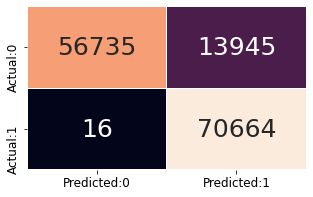


Confusion matrix test data


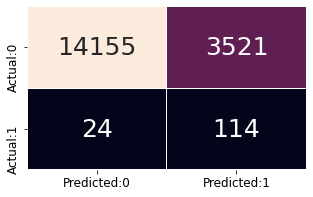


Recall(TPR) for test data = 0.8260869565217391


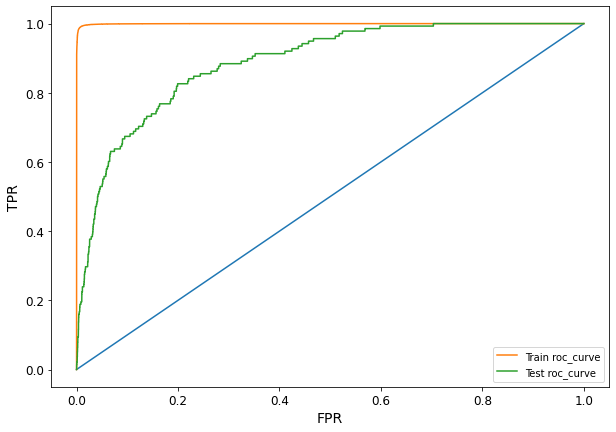

In [35]:
xg_tune = XGBClassifier(n_estimators=199,max_depth=4)

xg_tuned_train_f1, xg_tuned_test_f1, xg_tuned_train_roc,xg_tuned_test_roc, xg_tuned_train_acc, xg_tuned_test_acc,xgb_tuned_rec = model_eval(xg_tune)

In [36]:
models.append('XGB Tuned Classifier')
f1_train_scores.append(xg_tuned_train_f1)
f1_test_scores.append(xg_tuned_test_f1)
roc_train_scores.append(xg_tuned_train_roc)
roc_test_scores.append(xg_tuned_test_roc)
rec_test.append(xgb_tuned_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623
6,XGB Classifier,0.942222,0.082618,0.999688,0.881689,0.731884
7,XGB Tuned Classifier,0.910097,0.060429,0.999505,0.888121,0.826087


## LightGBM

In [37]:
lgb = LGBMClassifier(random_state=3)

Default accuracy score of the train data is:  0.9830998868138087
Default accuracy score of the test data is:  0.9706972044459414

Threshhold defined accuracy score of the train data is:  0.8877475947934352
Threshhold defined accuracy score of the test data is:  0.7756259122038845

F1 score of the train data is:  0.8990482491856678
F1 score of the test data is:  0.057533600565904265

roc_auc_score of the train data is:  0.9986423101769246
roc_auc_score of the test data is:  0.9040767223878443

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.78      0.87     70680
           1       0.82      1.00      0.90     70680

    accuracy                           0.89    141360
   macro avg       0.91      0.89      0.89    141360
weighted avg       0.91      0.89      0.89    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     17676
         

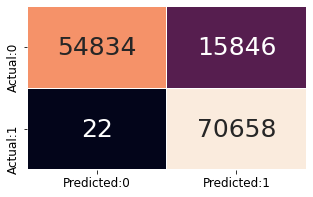


Confusion matrix test data


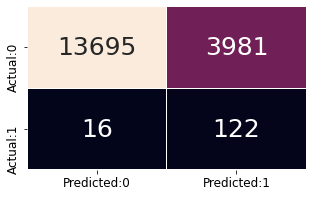


Recall(TPR) for test data = 0.8840579710144928


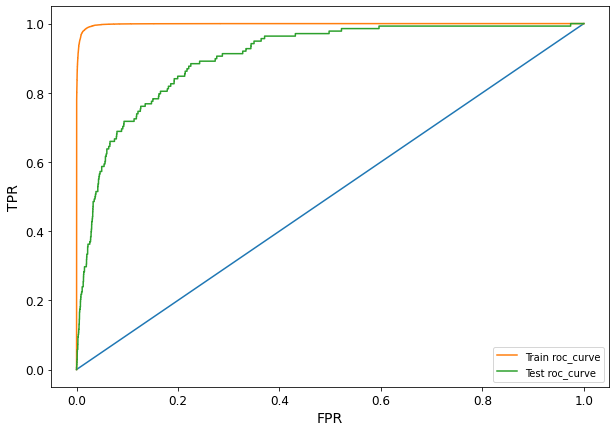

In [38]:
lgb_train_f1,lgb_test_f1,lgb_train_roc,lgb_test_roc,lgb_train_acc,lgb_test_acc,lgb_rec = model_eval(lgb)

In [39]:
models.append('LGBM Classifier')
f1_train_scores.append(lgb_train_f1)
f1_test_scores.append(lgb_test_f1)
roc_train_scores.append(lgb_train_roc)
roc_test_scores.append(lgb_test_roc)
rec_test.append(lgb_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623
6,XGB Classifier,0.942222,0.082618,0.999688,0.881689,0.731884
7,XGB Tuned Classifier,0.910097,0.060429,0.999505,0.888121,0.826087
8,LGBM Classifier,0.899048,0.057534,0.998642,0.904077,0.884058


## LightGBM - Hyperparameter Tuning

In [41]:
lgb_tuned = LGBMClassifier(random_state=3,n_jobs=-1)

params = {'n_estimators':np.arange(80,120)}

gscv = GridSearchCV(lgb_tuned,param_grid=params,cv=3,scoring='f1',n_jobs=-1,verbose=True)
gscv.fit(xtrain,ytrain)

Fitting 3 folds for each of 40 candidates, totalling 120 fits


GridSearchCV(cv=3, estimator=LGBMClassifier(random_state=3), n_jobs=-1,
             param_grid={'n_estimators': array([ 80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119])},
             scoring='f1', verbose=True)

In [42]:
gscv.best_params_

{'n_estimators': 119}

Default accuracy score of the train data is:  0.9854980192416525
Default accuracy score of the test data is:  0.9730549006399462

Threshhold defined accuracy score of the train data is:  0.8798670062252405
Threshhold defined accuracy score of the test data is:  0.7603008869428539

F1 score of the train data is:  0.8927280996538394
F1 score of the test data is:  0.05447298494242692

roc_auc_score of the train data is:  0.9989741807813114
roc_auc_score of the test data is:  0.9014292285289806

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     70680
           1       0.81      1.00      0.89     70680

    accuracy                           0.88    141360
   macro avg       0.90      0.88      0.88    141360
weighted avg       0.90      0.88      0.88    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.76      0.86     17676
          

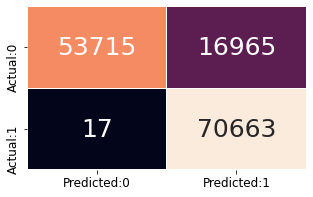


Confusion matrix test data


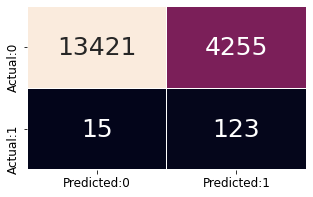


Recall(TPR) for test data = 0.8913043478260869


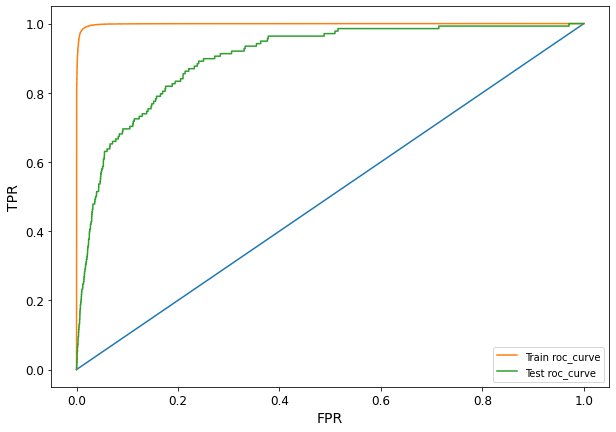

In [43]:
lgb_tuned = LGBMClassifier(random_state=3,n_jobs=-1,n_estimators=119)

lgm_tuned_train_f1, lgm_tuned_test_f1, lgm_tuned_train_roc, lgm_tuned_test_roc,lgm_tuned_train_acc, lgm_tuned_test_acc,lgb_tuned_rec = model_eval(lgb_tuned)

In [44]:
models.append('LGBM Tuned Classifier') 
f1_train_scores.append(lgm_tuned_train_f1)
f1_test_scores.append(lgm_tuned_test_f1)
roc_train_scores.append(lgm_tuned_train_roc)
roc_test_scores.append(lgm_tuned_test_roc)
rec_test.append(lgb_tuned_rec)

pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test})

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623
6,XGB Classifier,0.942222,0.082618,0.999688,0.881689,0.731884
7,XGB Tuned Classifier,0.910097,0.060429,0.999505,0.888121,0.826087
8,LGBM Classifier,0.899048,0.057534,0.998642,0.904077,0.884058
9,LGBM Tuned Classifier,0.892728,0.054473,0.998974,0.901429,0.891304


In [59]:
cv_model.append(lgb_tuned)
model_name.append('Hypertuned LightGBM model')
train_acc.append(lgm_tuned_train_acc)
test_acc.append(lgm_tuned_test_acc)

## Models in the order of performances

In [45]:
pd.DataFrame({'Models':models,'Train f1 score':f1_train_scores,'Test f1 scores':f1_test_scores,'Train ROC':roc_train_scores,'Test ROC':roc_test_scores,'Test Recall':rec_test}).sort_values(by=['Test Recall','Test ROC'],ascending=False)

,Models,Train f1 score,Test f1 scores,Train ROC,Test ROC,Test Recall
2,GradientBoost Classifier,0.910360,0.067750,0.986418,0.916791,0.891304
9,LGBM Tuned Classifier,0.892728,0.054473,0.998974,0.901429,0.891304
8,LGBM Classifier,0.899048,0.057534,0.998642,0.904077,0.884058
0,RandomForest Classifier,0.955154,0.071649,0.999998,0.890467,0.840580
3,GradientBoost Tuned Classifier,0.927087,0.080900,0.990192,0.912204,0.833333
7,XGB Tuned Classifier,0.910097,0.060429,0.999505,0.888121,0.826087
1,RandomForest Tuned Classifier,0.911334,0.085516,0.972698,0.903351,0.804348
5,SGD Tuned Classifier,0.842089,0.069728,0.913915,0.858434,0.753623
6,XGB Classifier,0.942222,0.082618,0.999688,0.881689,0.731884
4,SGD Classifier,0.840944,0.059567,0.904920,0.826701,0.717391


# Final Model Selection

Even though the models were built by optimising the f1 score and roc, the main aim of the project is to reduce False Negatives and to increase True positives. We have optimised this by using using the best value of Youden's index. The final models were selected on the basis of maximum number of true positves. The top 3 models performed as follows:

    1. GradientBoosting Base model - 123 True positives out of 138 Positives
    2. Hypertuned LightGBM model   - 123 True positives out of 138 Positives
    3. Hypertuned RandomForest     - 122 True positives out of 138 Positives
    
    
GradientBoost classifier gave a good TPR rate after hyperparameter tuning as well, but considering the fact that the base model already gave a better performance, we deicide on dropping it from the voting classifier.

Hyperparameter tuned XGBoost gave a good TPR, but the f1 score was lowest of the lot, and we can observe high level of overfitting from the train and test roc scores. Hence not being considered for the voting classsifier.

**Combining train and test for cross validation**

In [62]:
X = pd.concat([xtrain,xtest],axis = 0)
Y = pd.concat([ytrain,ytest],axis = 0)

In [63]:
X.shape,Y.shape

((159174, 15), (159174,))

## Cross valdation

The chosen models are cross validated on the basis of accuracy score. Kfold cross validation with 10 splits will be used for the same.

In [64]:
from sklearn.model_selection import cross_val_score,KFold

cv_score = []

for i,j in zip(model_name,cv_model):
    kfold = KFold(n_splits=10,shuffle=True,random_state=3)
    cv = cross_val_score(j,X,Y,cv=kfold,scoring='accuracy')
    cv_score.append(cv.mean())

cv_df = pd.DataFrame({'Models':model_name,'Train Accuracy':train_acc,'Test Accuracy':test_acc,'Cross Validated accuracy':cv_score})

In [65]:
cv_df

,Models,Train Accuracy,Test Accuracy,Cross Validated accuracy
0,RandomForest Tuned Classifier,0.910335,0.876109,0.908477
1,GradientBoosting Base Model,0.944263,0.927697,0.944934
2,Hypertuned LightGBM model,0.985498,0.973055,0.983597


### Results

We see that all models performed well, the cross validation accuracy is between the test score and train score for all the models. 

## Ensemble of the chosen models - Voting Classifier

In [66]:
model_name

['RandomForest Tuned Classifier',
 'GradientBoosting Base Model',
 'Hypertuned LightGBM model']

In [67]:
cv_model

[RandomForestClassifier(max_depth=7, n_estimators=117, n_jobs=-1, random_state=3),
 GradientBoostingClassifier(random_state=3),
 LGBMClassifier(n_estimators=119, random_state=3)]

Default accuracy score of the train data is:  0.9648344651952462
Default accuracy score of the test data is:  0.9491972605815651

Threshhold defined accuracy score of the train data is:  0.9111559139784946
Threshhold defined accuracy score of the test data is:  0.8230605142023127

F1 score of the train data is:  0.9182766451713659
F1 score of the test data is:  0.07239552678045909

roc_auc_score of the train data is:  0.9948796573003011
roc_auc_score of the test data is:  0.9172459340594469

Classification report train
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     70680
           1       0.85      1.00      0.92     70680

    accuracy                           0.91    141360
   macro avg       0.92      0.91      0.91    141360
weighted avg       0.92      0.91      0.91    141360



Classification report test
              precision    recall  f1-score   support

           0       1.00      0.82      0.90     17676
          

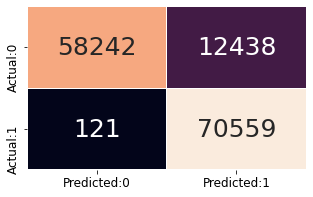


Confusion matrix test data


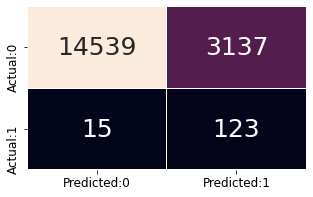


Recall(TPR) for test data = 0.8913043478260869


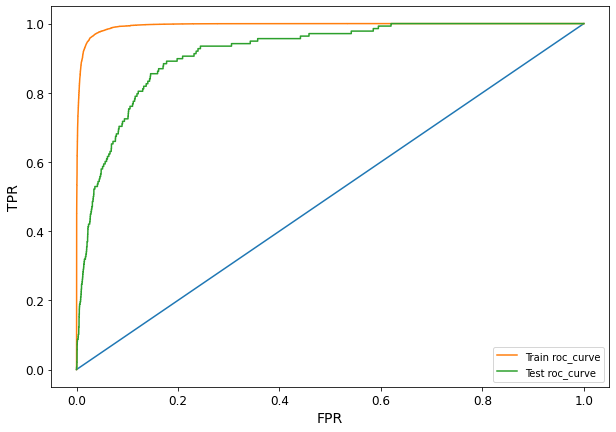

(0.9182766451713659,
 0.07239552678045909,
 0.9948796573003011,
 0.9172459340594469,
 0.9648344651952462,
 0.9491972605815651,
 0.8913043478260869)

In [68]:
clf1  = RandomForestClassifier(max_depth=7, n_estimators=117, n_jobs=-1, random_state=3)
clf2  = GradientBoostingClassifier(random_state=3)
clf3  = LGBMClassifier(n_estimators=113, random_state=3)

vc = VotingClassifier(estimators=[('RandomForest',clf1),('GradientBoosting',clf2),('LightGBM',clf3)], voting='soft')

model_eval(vc)

# Conclusion

Out of all the models tried RandomForest Classifier, GradientDescent, LightGBM Classifiers gave the maximum True positives, which in our case is the priority. By combining the power of the three models we managed to predict 123 True positives out of 138 Positives. 

## Voting Classifier Performances

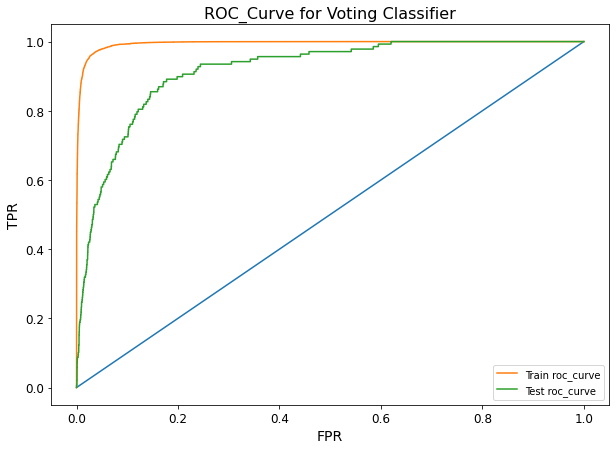

In [69]:
vc.fit(xtrain,ytrain)
    
yprob_train = vc.predict_proba(xtrain)[:,1]
yprob_test = vc.predict_proba(xtest)[:,1]
    
fpr,tpr,threshold = roc_curve(ytest,yprob_test)
j = tpr-fpr
i = np.argmax(j)
best_th = threshold[i]
    
ypred_train = list(map(lambda x :0 if x<best_th else 1,yprob_train))
ypred_test  = list(map(lambda x :0 if x<best_th else 1,yprob_test))

fpr,tpr,thresholds = roc_curve(ytest, yprob_test)
fpr1,tpr1,th1      = roc_curve(ytrain,yprob_train)
    
plt.figure(figsize=(10,7))
plt.title('ROC_Curve for Voting Classifier',fontsize=16)
plt.plot(fpr,fpr)
plt.plot(fpr1,tpr1,label='Train roc_curve')
plt.plot(fpr,tpr,label='Test roc_curve')
plt.xlabel('FPR',fontsize=14)
plt.ylabel('TPR',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend()
plt.show()

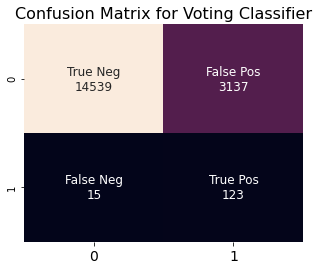

In [70]:
plt.figure(figsize=(5,4))
cf_matrix = confusion_matrix(ytest, ypred_test)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
plt.title('Confusion Matrix for Voting Classifier',fontsize=16)
ax=sns.heatmap(cf_matrix, annot=labels, fmt="",cbar=False,annot_kws={"size":12})
plt.xticks(fontsize=14)
plt.xticks(fontsize=14)
bottom, top = ax.get_ylim()
plt.show()

## Feature Importances

In [71]:
clf1.fit(xtrain,ytrain)
df_feature = pd.DataFrame(clf1.feature_importances_*100,columns=['important'])
df_feature['Feature_names']=xtrain.columns
dff=df_feature.sort_values(by='important',ascending=True)
dff

,important,Feature_names
8,0.000468,oe_constraint_Yes
11,0.000788,rev_stop_Yes
6,0.002890,potential_issue_Yes
10,0.099677,stop_auto_buy_Yes
9,0.784576,ppap_risk_Yes
4,1.570396,pieces_past_due
7,1.823989,deck_risk_Yes
3,3.996969,min_bank
5,4.207293,local_bo_qty
14,4.369139,performance_index


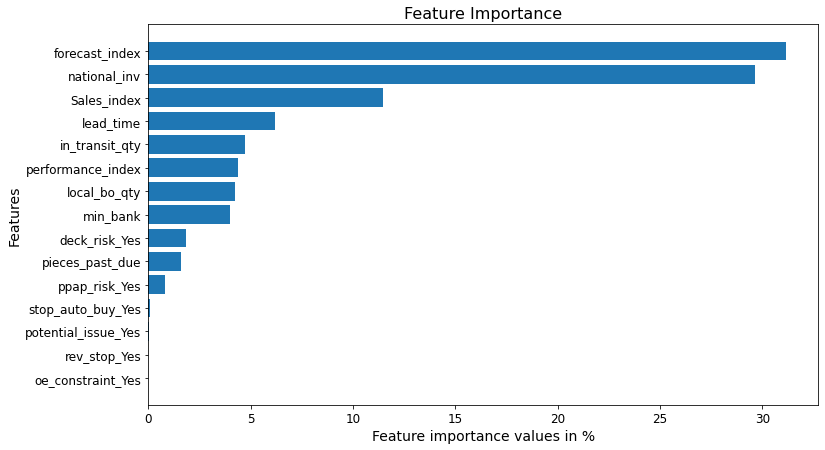

In [72]:
plt.figure(figsize=(12,7))
w=np.arange(15)
plt.barh(w,dff['important'])
plt.title("Feature Importance",fontsize=16)
plt.xlabel('Feature importance values in %',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(w,dff["Feature_names"])
plt.show()

In [73]:
clf2.fit(xtrain,ytrain)
df_feature = pd.DataFrame(clf2.feature_importances_*100,columns=['important'])
df_feature['Feature_names']=xtrain.columns
dff2=df_feature.sort_values(by='important',ascending=True)
dff2

,important,Feature_names
6,0.000000,potential_issue_Yes
8,0.000000,oe_constraint_Yes
10,0.000000,stop_auto_buy_Yes
11,0.000000,rev_stop_Yes
9,0.353773,ppap_risk_Yes
4,0.905857,pieces_past_due
7,1.164619,deck_risk_Yes
3,1.935320,min_bank
2,1.966725,in_transit_qty
14,2.186060,performance_index


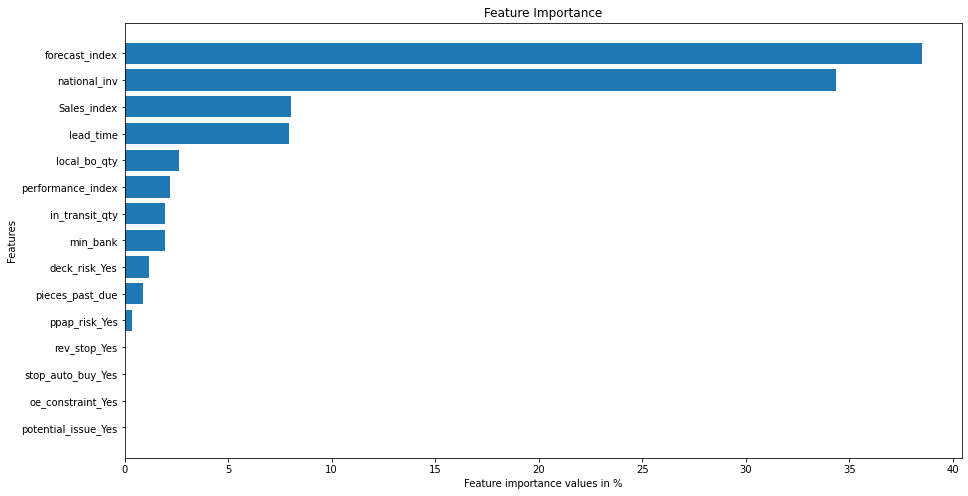

In [74]:
plt.figure(figsize=(15,8))
w2=np.arange(15)
plt.barh(w2,dff2['important'])
plt.title("Feature Importance")
plt.xlabel('Feature importance values in %')
plt.ylabel('Features')
plt.yticks(w2,dff2["Feature_names"])
plt.show()

In [75]:
clf3.fit(xtrain,ytrain)
df_feature = pd.DataFrame(clf3.feature_importances_,columns=['important'])
df_feature['Feature_names']=xtrain.columns
dff3=df_feature.sort_values(by='important',ascending=True)
dff3

,important,Feature_names
8,0,oe_constraint_Yes
11,0,rev_stop_Yes
6,7,potential_issue_Yes
10,12,stop_auto_buy_Yes
4,35,pieces_past_due
9,37,ppap_risk_Yes
7,58,deck_risk_Yes
5,72,local_bo_qty
2,237,in_transit_qty
3,325,min_bank


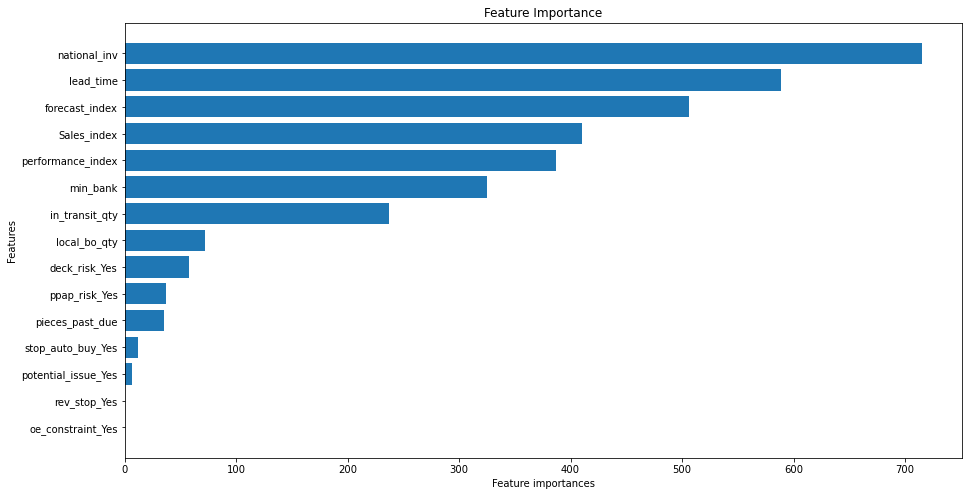

In [76]:
plt.figure(figsize=(15,8))
w3=np.arange(15)
plt.barh(w3,dff3['important'])
plt.title("Feature Importance")
plt.xlabel('Feature importances')
plt.ylabel('Features')
plt.yticks(w3,dff3["Feature_names"])
plt.show()

As all the 3-models were giving almost same feature_importances for the top-4 positions. Hence considered the Light GBM Tuned model as it gave the best performance out of the selected 3-models.

The top-5 important variables in predicting the backorder are:
    
    1. forecast_index = Cummulative Forecast sales for the next 9 months
    2. national_inv   = Current inventory level of part.
    3. Sales_index    = Cummulative Sales quantity for the prior 9 month time period
    4. lead_time      = Transit time for product (if available)
    5. in_transit_qty = Amount of product in transit from source
 

